## Portfolio Selection with Alternative Risk Measures
---

We consider the following three alternative risk measures:

+ **Mean absolute deviation**: $\mathrm{E}[ | R_P - \mu_P | ]$
+ **Semivariance**: $\mathrm{E}[(R_P - \mu_P)^2 | R_{Pt} \leqq \mu_P]$
+ **Expected shortfall**: $\mathrm{E}[-R_P|R_P\leqq\text{VaR}_\alpha]$ where $\Pr\{R_P\leqq\text{VaR}_\alpha\}=\alpha$


In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
marketcap = pd.read_csv('stock_market_cap.csv', index_col=0)
R = (marketcap.diff()/marketcap.shift(1))[1:] * 100
R.index = pd.date_range('2014-2-1', periods=R.shape[0], freq='M')
T, N = R.shape
Mu = R.mean().values

### Mean Absolute Deviation Optimization
---

The sample mean absolute deviation is

\begin{equation*}
 \varrho^{AD}(w) = \frac1{T}\sum_{t=1}^T|r_{P t}-\bar r_P|.
\end{equation*}

Define $v_t=r_{Pt}-\bar r_P$ and use the same notations as the minimum variance portfolio probem. Then we have

\begin{align*}
 \min_{w,v} & \quad \varrho^{AD}(w) = \frac1T\sum_{t=1}^T |v_t|, \\
 \text{subject to}
  & \quad Dw = v, \\
  & \quad w^{\intercal}\bar r = \mu_P, \quad w^{\intercal}\iota = 1, \\
  & \quad w_1\geqq 0,\ \cdots,\ w_N\geqq 0.
\end{align*}


In [2]:
Return_Dev = (R - Mu).values
Weight = cp.Variable(N)
Deviation = cp.Variable(T)
Target_Return = cp.Parameter()
Risk_AD = cp.norm(Deviation, 1) / T
Portfolio_AD = cp.Problem(cp.Minimize(Risk_AD),
                          [Return_Dev @ Weight == Deviation,
                           Weight.T @ Mu == Target_Return,
                           cp.sum(Weight) == 1.0,
                           Weight >= 0.0])

#### Miminum Mean Absolute Deviation Frontier

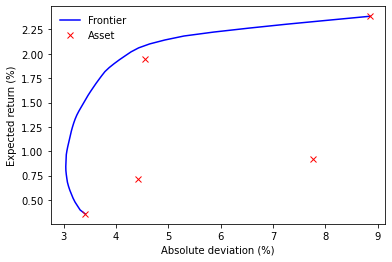

In [3]:
V_Target = np.linspace(Mu.min(), Mu.max(), num=51)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Portfolio_AD.solve(solver=cp.ECOS)
    V_Risk[idx] = Risk_AD.value
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot((R - Mu).abs().mean().values, Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Absolute deviation (%)')
plt.ylabel('Expected return (%)')
plt.show()

### Semivariance Optimization
---

The sample semivariance is

\begin{equation*}
 \varrho^{SV}(w) = \frac1T\sum_{t=1}^T\{[r_{Pt}-\bar r_P]^-\}^2,
\end{equation*}

where $[r_{Pt}-\bar r_P]^- =\max\{-(r_{Pt}-\bar r_P),0\}$ is call the negative part. Defining $v_t=[r_{Pt}-\bar r_P]^-$, we have

\begin{align*}
 \min_{w,v} &\quad \varrho^{SV}(w) = \frac1T\sum_{t=1}^T v_t^2, \\
 \text{subject to}      &\quad w^{\intercal}\bar r = \mu_P, \quad w^{\intercal}\iota = 1, \\
                  &\quad w_1\geqq 0,\ \cdots,\ w_N\geqq 0, 
                  \      v_1 \geqq 0,\ \cdots,\ v_T\geqq 0, \\
                  &\quad r_{P1}-\bar r_P + v_1 \geqq 0,\ \cdots,\ r_{PT}-\bar r_P + v_T \geqq 0.
\end{align*}


In [4]:
Return_Dev = (R - Mu).values
Weight = cp.Variable(N)
Deviation = cp.Variable(T)
Target_Return = cp.Parameter()
Risk_Semivariance = cp.sum_squares(Deviation) / T
Portfolio_SV = cp.Problem(cp.Minimize(Risk_Semivariance),
                          [Weight.T @ Mu == Target_Return,
                           cp.sum(Weight) == 1.0,
                           Weight >= 0.0,
                           Deviation >= 0.0,
                           Return_Dev @ Weight + Deviation >= 0.0])

#### Minimum Semivariance Fronfier

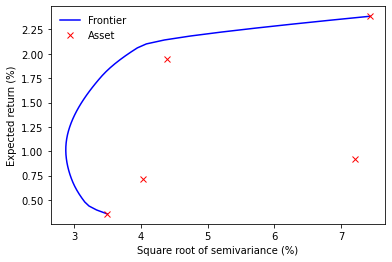

In [5]:
V_Target = np.linspace(Mu.min(), Mu.max(), num=51)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Portfolio_SV.solve(solver=cp.ECOS)
    V_Risk[idx] = np.sqrt(Risk_Semivariance.value)
fig2 = plt.figure(num=2, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot(np.sqrt(((R[R <= Mu] - Mu) ** 2).sum().values / T), Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Square root of semivariance (%)')
plt.ylabel('Expected return (%)')
plt.show()

### Expected Shortfall Optimization
---

The expected shortfall (ES) is given by 

\begin{equation*}
 \text{ES}_\alpha = \frac1{\alpha}\int_{-\infty}^\infty
 [R_P-\text{VaR}_\alpha]^-p(R_P)dR_P - \text{VaR}_\alpha.
\end{equation*}

This can be approximated by

\begin{equation*}
 \varrho^{ES}(w,c) = \frac1{\alpha T}\sum_{t=1}^T[r_{Pt}-c]^- - c.
\end{equation*}

Thus, by defining $v_t=[r_{P t}-c]^-$, we have

\begin{align*}
 \min_{w,v,c} & \quad \varrho^{ES}(w,c) = \frac1{\alpha T}\sum_{t=1}^T v_t -c, \\
 \text{\bf subject to} 
  &\quad w^{\intercal}\bar r = \mu_P, \quad w^{\intercal}\iota = 1, \\
  &\quad w_1\geqq 0,\ \cdots,\ w_N\geqq 0, \ v_1 \geqq 0,\ \cdots,\ v_T\geqq 0, \\
  &\quad r_{P1} - c + v_1 \geqq 0,\ \cdots,\ r_{PT} - c + v_T \geqq 0.
\end{align*}


In [6]:
Return = R.values
Weight = cp.Variable(N)
Deviation = cp.Variable(T)
VaR = cp.Variable()
inv_Alpha = cp.Parameter(nonneg=True)
Target_Return = cp.Parameter()
Risk_ES = cp.sum(Deviation) * inv_Alpha / T - VaR
Portfolio_ES = cp.Problem(cp.Minimize(Risk_ES),
                          [Weight.T @ Mu == Target_Return,
                           cp.sum(Weight) == 1.0,
                           Weight >= 0.0,
                           Deviation >= 0.0,
                           Return @ Weight - VaR + Deviation >= 0.0])

#### Opitimal Expected Shortfall Portfolio

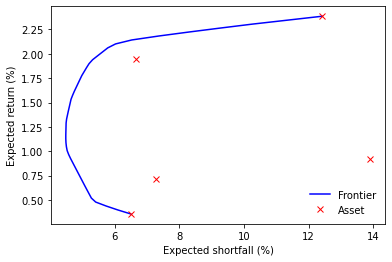

In [7]:
Alpha = 0.2
inv_Alpha.value = 1.0 / Alpha
V_Target = np.linspace(Mu.min(), Mu.max(), num=51)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Portfolio_ES.solve(solver=cp.ECOS)
    V_Risk[idx] = Risk_ES.value
fig3 = plt.figure(num=3, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot((-R[R <= R.quantile(Alpha)]).mean().values, Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Expected shortfall (%)')
plt.ylabel('Expected return (%)')
plt.show()